In [24]:
## Model Evaluation for XGBoost ##
## Import libraries and data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost
import seaborn as sns
from Forecasters import TSDatasetGenerator, RFForecaster
from sklearn.metrics import average_precision_score, precision_recall_curve, \
    plot_precision_recall_curve, confusion_matrix, classification_report
from sklearn.metrics import log_loss
from datetime import datetime
from matplotlib.dates import date2num

from sklearn.ensemble import RandomForestClassifier as RFC

In [3]:
## Load data
# With dates
train_data_date = pd.read_csv('rec_train.csv').drop(columns=['Unnamed: 0'])
test_data_date = pd.read_csv('rec_test.csv').drop(columns=['Unnamed: 0'])
# Without dates
train_data = pd.read_csv('rec_train.csv').drop(columns=['Unnamed: 0', 'DATE'])
test_data = pd.read_csv('rec_test.csv').drop(columns=['Unnamed: 0', 'DATE'])

In [4]:
## Get dates for plotting
train_dates = train_data_date['DATE']
test_dates = test_data_date['DATE']
recession_dates = [('1969-12-01', '1970-11-01'),
                   ('1973-11-01', '1975-03-01'),
                   ('1980-01-01', '1980-07-01'),
                   ('1981-07-01', '1982-11-01'),
                   ('1990-07-01', '1991-03-01'),
                   ('2001-03-01', '2001-11-01'),
                   ('2007-12-01', '2009-06-01')]
train_recession_dates = recession_dates[0:5]
test_recession_dates = recession_dates[5:]

In [5]:
## Auxiliary functions to generate metrics
def genClassificationRep(y_true, y_pred):
    return pd.DataFrame(classification_report(y_true, y_pred, output_dict=True))

In [7]:
def plot_pr_curve(classifier, X_test, y_test):
    y_score = classifier.predict_proba(X_test)[:, 1]  # Get prediction probs for positive class
    average_precision = average_precision_score(y_test, y_score)
    plt.figure(figsize=(10, 5))
    disp = plot_precision_recall_curve(classifier, X_test, y_test)
    disp.ax_.set_title('Recession prediction: PR Curve with AP = {0:0.2f}'.format(average_precision))
    return disp

In [112]:
def plot_recession_curve(dates, y_pred, data_type, h, l, k):
    formatted_dates = dates.iloc[max(l, k)+h:]
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(formatted_dates, y_pred)
    rec_dates = train_recession_dates if data_type == 'Train' else test_recession_dates
    for start, end in rec_dates:
        ax.axvspan(start,
                   end,
                   label="Recession", color="red", alpha=0.3)
    ax.set_title("Probability of Recession Occurring: {}-month forecast - {} data ({} y-lags, {} x-lags)".format(h, data_type, l, k))
    ax.legend(["Predicted", "Actual"])
    ax.set_xticks(np.arange(12 - h, len(formatted_dates), 24))
    ax.tick_params(axis='x', labelrotation=45)
    ax.set_ylim([0, 1.05])
    plt.show()

In [123]:
def plot_recession_curve(dates, y_pred, data_type, h, l, k):
    formatted_dates = dates.iloc[max(l, k):-h, ]
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(formatted_dates, y_pred)
    rec_dates = train_recession_dates if data_type == 'Train' else test_recession_dates
    for start, end in rec_dates:
        if start >= formatted_dates[max(l, k)+h]:
            ax.axvspan(start,end,label="Recession", color="red", alpha=0.3)
        else:
            ax.axvspan(formatted_dates[max(l, k)+h],end,label="Recession", color="red", alpha=0.3)
    ax.set_title("Probability of Recession Occurring: {}-month forecast - {} data ({} y-lags, {} x-lags)".format(h, data_type, l, k))
    ax.legend(["Predicted", "Actual"])
    ax.set_xticks(np.arange(12 - h, len(formatted_dates), 24))
    ax.tick_params(axis='x', labelrotation=45)
    ax.set_ylim([0, 1.05])
    plt.show()

In [42]:
def fit_model(model, dataset, val_dataset):
    X_train, y_train, X_val, y_val = get_train_test(dataset, val_dataset)
    model.fit(X_train,
              y_train)
    return model

In [43]:
def get_train_test(dataset, val_dataset):
    X_train = dataset.drop(columns=['Target Feature'])
    y_train = dataset['Target Feature']
    X_val = val_dataset.drop(columns=['Target Feature'])
    y_val = val_dataset['Target Feature']
    return (X_train, y_train, X_val, y_val)

In [44]:
def plt_featimpt(feat_impt, feat_names):
    data = pd.concat([pd.DataFrame(feat_names, columns=['Feature']), pd.DataFrame(feat_impt, columns=['Importance (Gain)'])], axis=1).sort_values(by=['Importance (Gain)'], ascending=False)
    sns.barplot(x='Importance (Gain)', y='Feature', data=data)
    plt.show()

In [45]:
## Instantiate dataset generator
dg = TSDatasetGenerator()

In [46]:
## Best 1 step model ##
# Best params
best_onestep_rf = {'bootstrap': True,
                   'class_weight': 'balanced',
                   'criterion': 'gini',
                   'n_estimators': 100,
                   'max_depth': 4,
                   'random_state': 42,
                  }

rf_one_step = RFC()
rf_one_step.set_params(**best_onestep_rf)

RandomForestClassifier(class_weight='balanced', max_depth=4, random_state=42)

In [60]:
# Best dataset (In and out of sample)
one_step_train = dg.fit_transform(train_data, 'Is_Recession', 1, 0, 0)
one_step_test = dg.fit_transform(test_data, 'Is_Recession', 1, 0, 0)
X_train_one, y_train_one, X_test_one, y_test_one = get_train_test(one_step_train, one_step_test)

Dropping any existing invalid observations
Dropping any existing invalid observations


In [61]:
## MODEL
# Fit model
rf_one_step = fit_model(rf_one_step, one_step_train, one_step_test)
# Predict (In sample)
y_pred_one_train = rf_one_step.predict(X_train_one)

<Figure size 720x360 with 0 Axes>

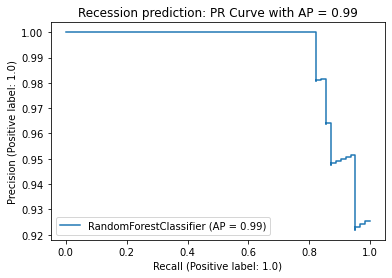

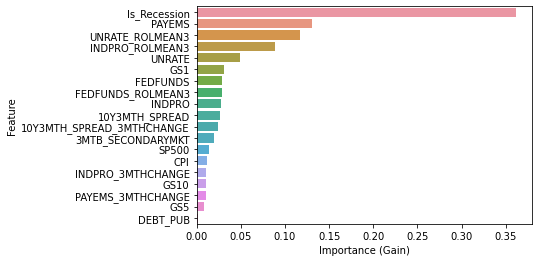

In [70]:
## IN SAMPLE
# Classification Report (In sample)
clf_rep_one_train = genClassificationRep(y_train_one, y_pred_one_train)
# Confusion matrix
confusion_matrix(y_train_one, y_pred_one_train)
# Precision recall graphs (In sample)
pr_curve_one_train = plot_pr_curve(rf_one_step, X_train_one, y_train_one)
plt.show()
# Feature Importance
plt_featimpt(rf_one_step.feature_importances_, X_train_one.columns)

<Figure size 720x360 with 0 Axes>

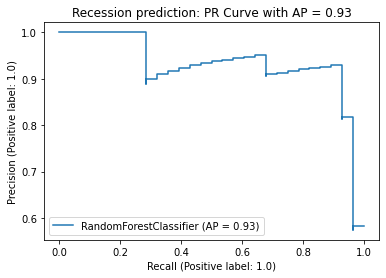

,0.0,1.0,accuracy,macro avg,weighted avg
precision,0.990521,0.928571,0.983264,0.959546,0.983264
recall,0.990521,0.928571,0.983264,0.959546,0.983264
f1-score,0.990521,0.928571,0.983264,0.959546,0.983264
support,211.000000,28.000000,0.983264,239.000000,239.000000


In [139]:
## OOS
# Predict (Out of sample)
y_pred_one = rf_one_step.predict(X_test_one)
# Classification Report (Out of sample)
clf_rep_one = genClassificationRep(y_test_one, y_pred_one)
# Log Loss
log_loss(y_test_one, y_pred_one)
# Confusion matrix
confusion_matrix(y_test_one, y_pred_one)
# Precision recall graphs (Out of sample)
pr_curve_one = plot_pr_curve(rf_one_step, X_test_one, y_test_one)
plt.show()

clf_rep_one

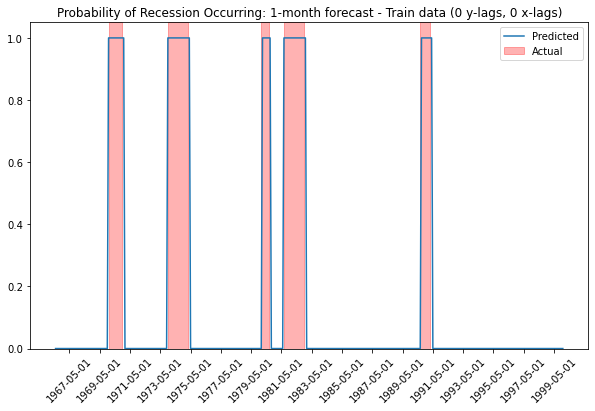

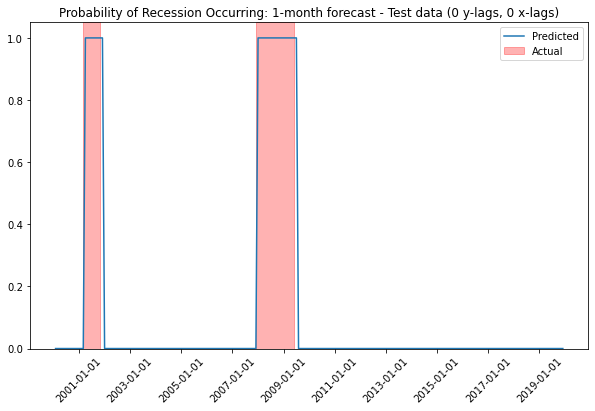

In [65]:
## Recession prediction graph (In and Out of sample)
# In Sample
plot_recession_curve(train_dates, y_pred_one_train, 'Train', 1, 0, 0)
plt.show()
# Out of Sample
plot_recession_curve(test_dates, y_pred_one, 'Test', 1, 0, 0)
plt.show()

In [84]:
## Best 3 step model ##
# Best params
best_threestep_rf = {'bootstrap': True,
                   'class_weight': 'balanced',
                   'criterion': 'gini',
                   'n_estimators': 100,
                   'max_depth': 4,
                   'random_state': 42,
                  }

rf_three_step = RFC()
rf_three_step.set_params(**best_threestep_rf)

RandomForestClassifier(class_weight='balanced', max_depth=4, random_state=42)

In [85]:
# Best dataset (In and out of sample)
three_step_train = dg.fit_transform(train_data, 'Is_Recession', 3, 0, 2)
three_step_test = dg.fit_transform(test_data, 'Is_Recession', 3, 0, 2)
X_train_three, y_train_three, X_test_three, y_test_three = get_train_test(three_step_train, three_step_test)

Dropping any existing invalid observations
Dropping any existing invalid observations


In [86]:
## MODEL
# Fit model
rf_three_step = fit_model(rf_three_step, three_step_train, three_step_test)
# Predict (In sample)
y_pred_three_train = rf_three_step.predict(X_train_three)

<Figure size 720x360 with 0 Axes>

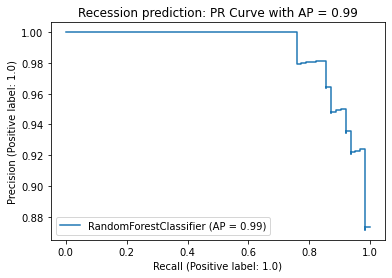

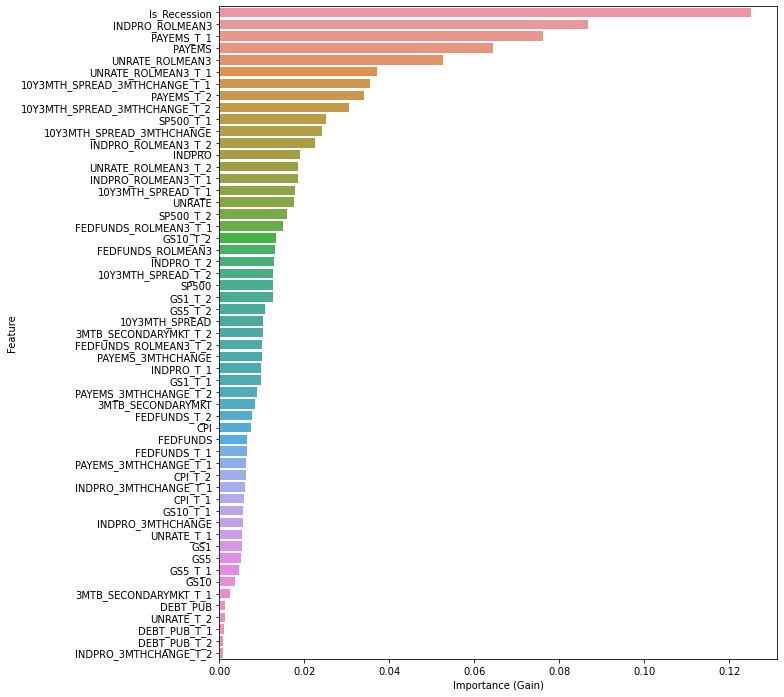

,0.0,1.0,accuracy,macro avg,weighted avg
precision,0.988131,0.935484,0.97995,0.961807,0.97995
recall,0.988131,0.935484,0.97995,0.961807,0.97995
f1-score,0.988131,0.935484,0.97995,0.961807,0.97995
support,337.000000,62.000000,0.97995,399.000000,399.00000


In [138]:
## IN SAMPLE
# Classification Report (In sample)
clf_rep_three_train = genClassificationRep(y_train_three, y_pred_three_train)
# Confusion matrix
confusion_matrix(y_train_three, y_pred_three_train)
# Precision recall graphs (In sample)
pr_curve_three_train = plot_pr_curve(rf_three_step, X_train_three, y_train_three)
plt.show()
# Feature Importance
plt.figure(figsize = (10,12))
plt_featimpt(rf_three_step.feature_importances_, X_train_three.columns)

clf_rep_three_train

<Figure size 720x360 with 0 Axes>

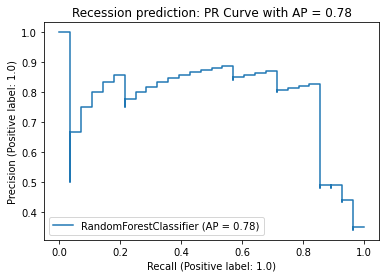

In [88]:
## OOS
# Predict (Out of sample)
y_pred_three = rf_three_step.predict(X_test_three)
# Classification Report (Out of sample)
clf_rep_three = genClassificationRep(y_test_three, y_pred_three)
# Log Loss
log_loss(y_test_three, y_pred_three)
# Confusion matrix
confusion_matrix(y_test_three, y_pred_three)
# Precision recall graphs (Out of sample)
pr_curve_three = plot_pr_curve(rf_three_step, X_test_three, y_test_three)
plt.show()

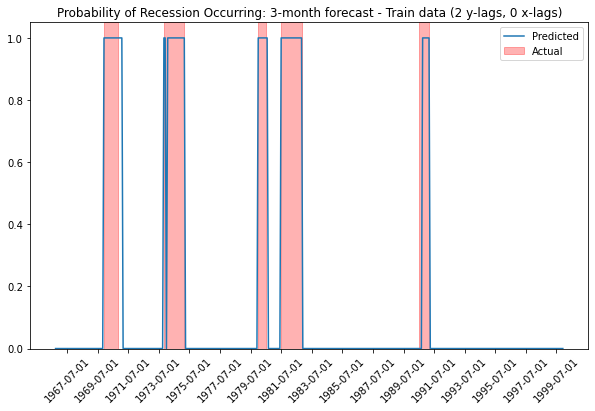

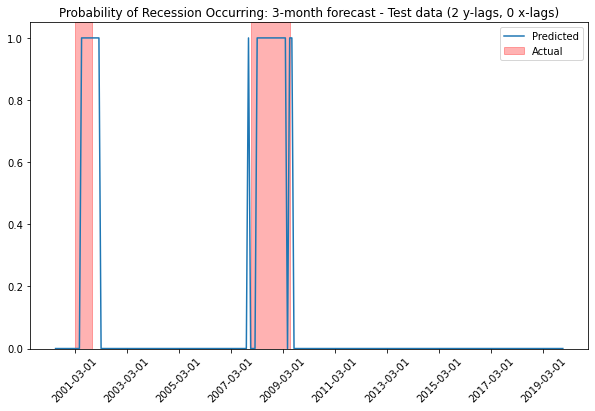

In [89]:
## Recession prediction graph (In and Out of sample)
# In Sample
plot_recession_curve(train_dates, y_pred_three_train, 'Train', 3, 2, 0)
plt.show()
# Out of Sample
plot_recession_curve(test_dates, y_pred_three, 'Test', 3, 2, 0)
plt.show()

In [91]:
## Best 6 step model ##
# Best params
best_sixstep_rf = {'bootstrap': True,
                   'class_weight': 'balanced',
                   'criterion': 'gini',
                   'n_estimators': 300,
                   'max_depth': 4,
                   'random_state': 42,
                  }

rf_six_step = RFC()
rf_six_step.set_params(**best_sixstep_rf)

# Best dataset (In and out of sample)
six_step_train = dg.fit_transform(train_data, 'Is_Recession', 6, 1, 0)
six_step_test = dg.fit_transform(test_data, 'Is_Recession', 6, 1, 0)
X_train_six, y_train_six, X_test_six, y_test_six = get_train_test(six_step_train, six_step_test)

Dropping any existing invalid observations
Dropping any existing invalid observations


<Figure size 720x360 with 0 Axes>

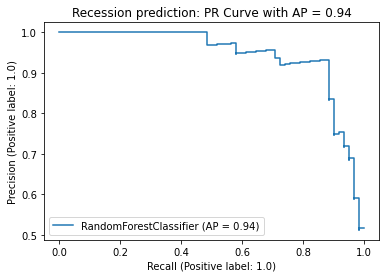

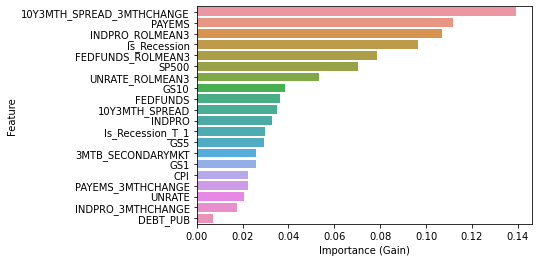

,0.0,1.0,accuracy,macro avg,weighted avg
precision,0.978852,0.833333,0.95466,0.906093,0.956126
recall,0.967164,0.887097,0.95466,0.927130,0.954660
f1-score,0.972973,0.859375,0.95466,0.916174,0.955232
support,335.000000,62.000000,0.95466,397.000000,397.000000


In [141]:
## MODEL
# Fit model
rf_six_step = fit_model(rf_six_step, six_step_train, six_step_test)
# Predict (In sample)
y_pred_six_train = rf_six_step.predict(X_train_six)

## IN SAMPLE
# Classification Report (In sample)
clf_rep_six_train = genClassificationRep(y_train_six, y_pred_six_train)
# Confusion matrix
confusion_matrix(y_train_six, y_pred_six_train)
# Precision recall graphs (In sample)
pr_curve_six_train = plot_pr_curve(rf_six_step, X_train_six, y_train_six)
plt.show()
# Feature Importance
plt_featimpt(rf_six_step.feature_importances_, X_train_six.columns)

clf_rep_six_train

<Figure size 720x360 with 0 Axes>

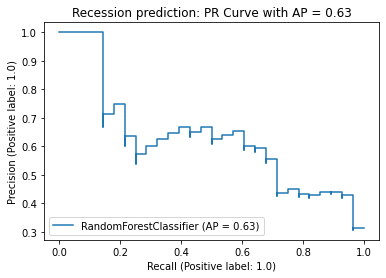

,0.0,1.0,accuracy,macro avg,weighted avg
precision,0.912844,0.600000,0.892704,0.756422,0.875249
recall,0.970732,0.321429,0.892704,0.646080,0.892704
f1-score,0.940898,0.418605,0.892704,0.679751,0.878133
support,205.000000,28.000000,0.892704,233.000000,233.000000


In [142]:
## OOS
# Predict (Out of sample)
y_pred_six = rf_six_step.predict(X_test_six)
# Classification Report (Out of sample)
clf_rep_six = genClassificationRep(y_test_six, y_pred_six)
# Log Loss
log_loss(y_test_six, y_pred_six)
# Confusion matrix
confusion_matrix(y_test_six, y_pred_six)
# Precision recall graphs (Out of sample)
pr_curve_six = plot_pr_curve(rf_six_step, X_test_six, y_test_six)
plt.show()

clf_rep_six

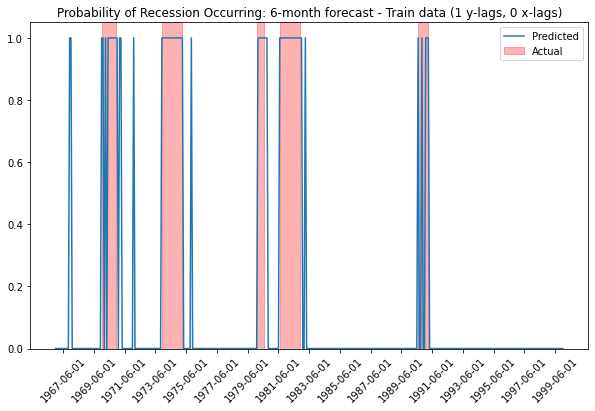

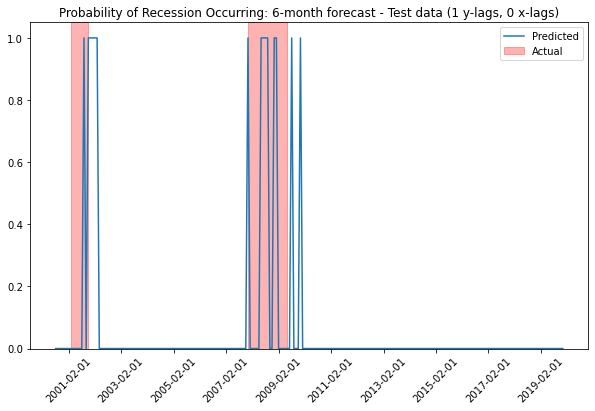

In [94]:
## Recession prediction graph (In and Out of sample)
# In Sample
plot_recession_curve(train_dates, y_pred_six_train, 'Train', 6, 1, 0)
plt.show()
# Out of Sample
plot_recession_curve(test_dates, y_pred_six, 'Test', 6, 1, 0)
plt.show()

In [96]:
## Best 12 step model ##
# Best params
best_twstep_rf = {'bootstrap': True,
                   'class_weight': 'balanced',
                   'criterion': 'gini',
                   'n_estimators': 100,
                   'max_depth': 4,
                   'random_state': 42,
                 }

rf_tw_step = RFC()
rf_tw_step.set_params(**best_twstep_rf)

# Best dataset (In and out of sample)
tw_step_train = dg.fit_transform(train_data, 'Is_Recession', 12, 0, 3)
tw_step_test = dg.fit_transform(test_data, 'Is_Recession', 12, 0, 3)
X_train_tw, y_train_tw, X_test_tw, y_test_tw = get_train_test(tw_step_train, tw_step_test)

Dropping any existing invalid observations
Dropping any existing invalid observations


<Figure size 720x360 with 0 Axes>

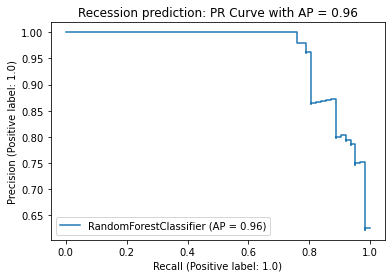

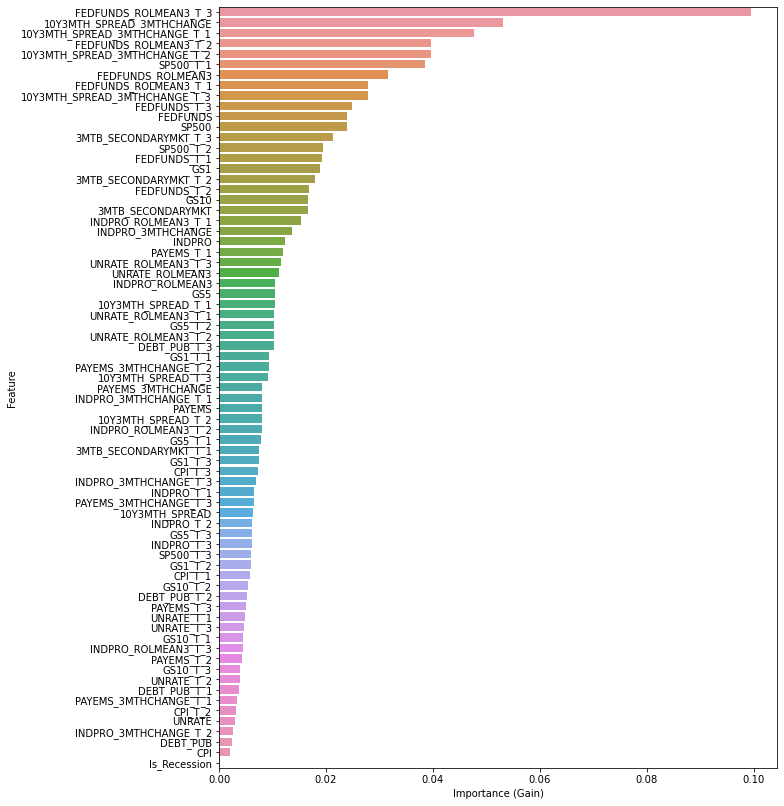

In [99]:
## MODEL
# Fit model
rf_tw_step = fit_model(rf_tw_step, tw_step_train, tw_step_test)
# Predict (In sample)
y_pred_tw_train = rf_tw_step.predict(X_train_tw)

## IN SAMPLE
# Classification Report (In sample)
clf_rep_tw_train = genClassificationRep(y_train_tw, y_pred_tw_train)
# Confusion matrix
confusion_matrix(y_train_tw, y_pred_tw_train)
# Precision recall graphs (In sample)
pr_curve_tw_train = plot_pr_curve(rf_tw_step, X_train_tw, y_train_tw)
plt.show()
# Feature Importance
plt.figure(figsize=(10,14))
plt_featimpt(rf_tw_step.feature_importances_, X_train_tw.columns)

/Users/elisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/elisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/elisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 720x360 with 0 Axes>

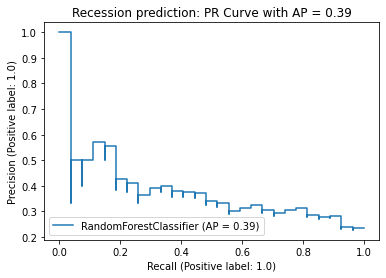

,0.0,1.0,accuracy,macro avg,weighted avg
precision,0.88000,0.0,0.88,0.440000,0.77440
recall,1.00000,0.0,0.88,0.500000,0.88000
f1-score,0.93617,0.0,0.88,0.468085,0.82383
support,198.00000,27.0,0.88,225.000000,225.00000


In [143]:
## OOS
# Predict (Out of sample)
y_pred_tw = rf_tw_step.predict(X_test_tw)
# Classification Report (Out of sample)
clf_rep_tw = genClassificationRep(y_test_tw, y_pred_tw)
# Log Loss
log_loss(y_test_tw, y_pred_tw)
# Confusion matrix
confusion_matrix(y_test_tw, y_pred_tw)
# Precision recall graphs (Out of sample)
pr_curve_tw = plot_pr_curve(rf_tw_step, X_test_tw, y_test_tw)
plt.show()
clf_rep_tw

clf_rep_tw

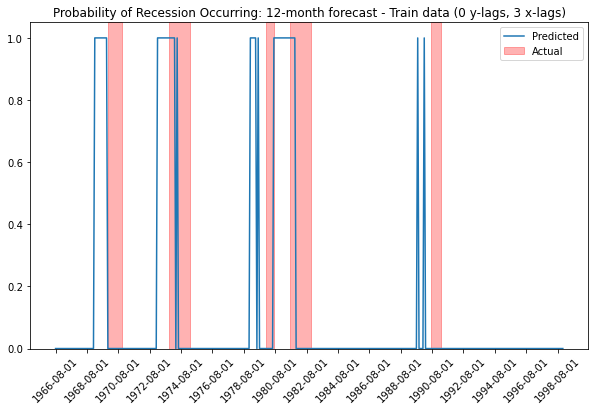

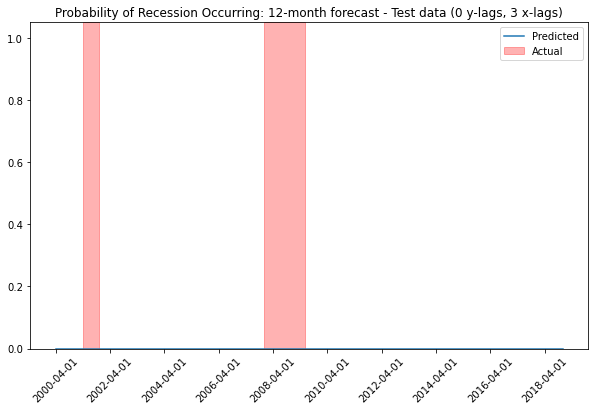

In [124]:
## Recession prediction graph (In and Out of sample)
# In Sample
plot_recession_curve(train_dates, y_pred_tw_train, 'Train', 12, 0, 3)
plt.show()
# Out of Sample
plot_recession_curve(test_dates, y_pred_tw, 'Test', 12, 0, 3)
plt.show()

In [135]:
## Churn out predictions for GR model
## 1 Step ahead
pd.concat([y_test_one.to_frame('y_test_1'), pd.DataFrame(rf_one_step.predict_proba(X_test_one)[:, 1], columns=['y_pred_1'])], axis=1).to_csv('RF_results_1.csv', index=False)

In [136]:
## 3 Step ahead
pd.concat([y_test_three.to_frame('y_test_3'), pd.DataFrame(rf_three_step.predict_proba(X_test_three)[:, 1], columns=['y_pred_3'])], axis=1).to_csv('RF_results_3.csv', index=False)

In [132]:
## 6 Step ahead
pd.concat([y_test_six.to_frame('y_test_6'), pd.DataFrame(rf_six_step.predict_proba(X_test_six)[:, 1], columns=['y_pred_6'])], axis=1).to_csv('RF_results_6.csv', index=False)

In [134]:
## 12 Step ahead
pd.concat([y_test_tw.to_frame('y_test_12'), pd.DataFrame(rf_tw_step.predict_proba(X_test_tw)[:, 1], columns=['y_pred_12'])], axis=1).to_csv('RF_results_12.csv', index=False)